In [6]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from collections import Counter
import re
import seaborn as sns
import numpy as np
import itertools

In [7]:
train_df = pd.read_csv('dataset/TRAIN.csv', header=None, sep='\t', 
                  names=["Sequence"])

train_df["Sequence"] = train_df["Sequence"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

pos_dict = {}
words = {}
index = 1

for sequence in train_df["Sequence"]:
    for word, pos in sequence:
        pos_dict[pos] = pos_dict.get(pos, 0) + 1

        if word not in words:
            words[word] = index
            index += 1

train_df.shape

(52499, 1)

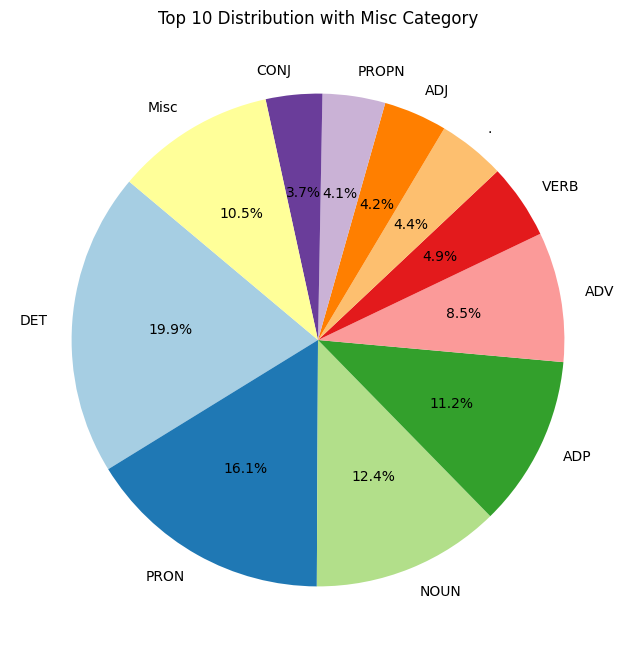

In [8]:
n = 1

start_counts = {}
index_counts = {}
index = 1
total = 0

for row in train_df['Sequence']:
    for i in range(n):
        if i >= len(row):
            break

        start_counts[row[i][1]] = start_counts.get(row[i][1], 0) + 1

        if row[i][1] not in index_counts:
            index_counts[row[i][1]] = index
            index += 1
        
        total += 1

sorted_counts = sorted(start_counts.items(), key=lambda x: x[1], reverse=True)

top_10 = sorted_counts[:10]
top_labels = [label for label, count in top_10]
top_values = [count for label, count in top_10]

misc_value = sum(count for label, count in sorted_counts[10:])
if misc_value > 0:
    top_labels.append("Misc")
    top_values.append(misc_value)

plt.figure(figsize=(8, 8))
plt.pie(top_values, labels=top_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

plt.title("Top 10 Distribution with Misc Category")
plt.show()

In [9]:
class_names = sorted(set(row[0][1] for row in train_df['Sequence']))

prob_matrix = np.zeros((1, len(class_names)))

for j, class_name in enumerate(class_names):
    prob_matrix[0, j] = start_counts.get(class_name, 0) / total  

df_prob = pd.DataFrame(prob_matrix, columns=class_names, index=["Start"])

print(df_prob)

df_prob.to_csv("dataset/start_probability_matrix.csv", index=False)


             .       ADJ       ADP       ADV       AUX    CCONJ     CONJ  \
Start  0.04421  0.041639  0.112459  0.085259  0.006533  0.00541  0.03701   

            DET      INTJ      NOUN  ...      PART      PRON     PROPN  \
Start  0.198975  0.008533  0.123983  ...  0.001333  0.161375  0.041144   

            PRT     PUNCT     SCONJ       SYM      VERB         X         _  
Start  0.023658  0.009695  0.008667  0.001714  0.049201  0.005962  0.010553  

[1 rows x 21 columns]


In [10]:
pos_transitions = np.zeros((int(pow(21, n)), 21))
pos_tags = index_counts.keys()
result = pos_tags


def combine_arrays(arr1, arr2):
  result = []
  for item1 in arr1:
    for item2 in arr2:
      result.append(item1 + " " + item2)
  return result

if n >= 2:
    for i in range(2, n + 1):
        result = combine_arrays(result, pos_tags)

for row in train_df['Sequence']:
    pos_queue = []
    index = 0
    row_index = 1

    for word, pos in row:
        pos_queue.append(pos)

        if index >= n:
            if index > n:
                row_index = row_index // index_counts[pos_queue[-2 - 1*n]]

            pos_transitions[row_index - 1][index_counts[pos] - 1] += 1

        row_index *= index_counts[pos]
        index += 1

df_prob = pd.DataFrame(pos_transitions, columns=pos_tags, index=result)

row_totals = df_prob.sum(axis=1)
df_prob_normalized = df_prob.div(row_totals, axis=0)
df_prob_normalized = df_prob_normalized.where(row_totals > 0, df_prob)
df_prob_normalized.to_csv("dataset/transition_probability_matrix.csv")

print(df_prob_normalized.head())

            NUM       DET      VERB     PROPN      PRON      NOUN       ADP  \
NUM    0.053798  0.010606  0.035649  0.011196  0.007542  0.363679  0.108892   
DET    0.011445  0.006556  0.058028  0.016947  0.008759  0.608627  0.009873   
VERB   0.010792  0.165595  0.161798  0.005109  0.063577  0.097786  0.172135   
PROPN  0.027242  0.003968  0.080974  0.291774  0.007454  0.078346  0.059470   
PRON   0.002191  0.017791  0.536688  0.003399  0.015969  0.060396  0.048768   

            AUX         .       PRT  ...      INTJ       ADV     SCONJ  \
NUM    0.002534  0.186023  0.003830  ...  0.000118  0.015026  0.000825   
DET    0.000285  0.010408  0.001503  ...  0.000009  0.017655  0.000026   
VERB   0.000962  0.059642  0.048837  ...  0.000171  0.097410  0.005755   
PROPN  0.044455  0.000000  0.000000  ...  0.000268  0.013406  0.004236   
PRON   0.113729  0.054111  0.014270  ...  0.000655  0.051511  0.002764   

           CONJ         _     PUNCT         X       ADJ       SYM      PART  
NU

In [11]:
emissive_prob = np.zeros((21, len(words)))

for row in train_df['Sequence']:
    for i in range(len(row)):
        emissive_prob[index_counts[row[i][1]] - 1][words[row[i][0]] - 1] += 1

df_prob = pd.DataFrame(emissive_prob, columns=list(words.keys()), index = pos_dict.keys())

row_totals = df_prob.sum(axis=1)
df_prob_normalized = df_prob.div(row_totals, axis=0)
df_prob_normalized = df_prob_normalized.where(row_totals > 0, df_prob)

df_prob_normalized.to_csv("dataset/emissive_probability_matrix.csv")
print(df_prob_normalized.head())

      03/01/2001     01:35   PM       The  industry       has      said  \
NUM     0.000058  0.000058  0.0  0.000000       0.0  0.000000  0.000000   
NOUN    0.000000  0.000000  0.0  0.055905       0.0  0.000000  0.000000   
DET     0.000000  0.000000  0.0  0.000000       0.0  0.014878  0.010064   
VERB    0.000000  0.000000  0.0  0.000153       0.0  0.000000  0.000000   
ADJ     0.000000  0.000000  0.0  0.000020       0.0  0.000000  0.000000   

          1960       was         a  ...  computations  mea  culpas  \
NUM   0.007931  0.000000  0.000292  ...           0.0  0.0     0.0   
NOUN  0.000000  0.000000  0.169071  ...           0.0  0.0     0.0   
DET   0.000000  0.040571  0.000000  ...           0.0  0.0     0.0   
VERB  0.000000  0.000000  0.000000  ...           0.0  0.0     0.0   
ADJ   0.000000  0.000000  0.000000  ...           0.0  0.0     0.0   

      scapegoats  slave-owners  MKM's  *-150  *-151  mosquito-plagued  \
NUM          0.0           0.0    0.0    0.0    0.0    